<a href="https://colab.research.google.com/github/Bhuvanesh003/FACE-DETECTION-AND-RECOGNITION-with-ATTEDNANCE-SYSTEM/blob/main/Just_Look_For_Presence.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install mtcnn

     |████████████████████████████████| 2.3 MB 12.7 MB/s 


In [ ]:
# confirm mtcnn was installed correctly
import mtcnn

!pip install  gspread --upgrade
# print version
print(mtcnn.__version__)

  Attempting uninstall: gspread
    Found existing installation: gspread 3.4.2
    Uninstalling gspread-3.4.2:
      Successfully uninstalled gspread-3.4.2
0.1.0


WEBCAM 

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

EXTRACT FACE

In [ ]:

from os import listdir
from os.path import isdir
from PIL import Image
from matplotlib import pyplot
from numpy import savez_compressed
from numpy import asarray
from mtcnn.mtcnn import MTCNN

# extract a single face from a given photograph
def extract_face(filename, required_size=(160, 160)):
    # load image from file
    image = Image.open(filename)
    # convert to RGB, if needed
    image = image.convert('RGB')
    # convert to array
    pixels = asarray(image)
    # create the detector, using default weights
    detector = MTCNN()
    # detect faces in the image
    results = detector.detect_faces(pixels)
    # extract the bounding box from the first face
    #if(len(results)!=0):
    x1, y1, width, height = results[0]['box']       
    # bug fix
    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1 + width, y1 + height
    # extract the face
    face = pixels[y1:y2, x1:x2]
    # resize pixels to the model size
    image = Image.fromarray(face)
    image = image.resize(required_size)
    face_array = asarray(image)
    return face_array

LOAD FACE FROM DIRECTORY

In [ ]:

# load images and extract faces for all images in a directory
def load_faces(directory):
    faces = list()
    # enumerate files
    for filename in listdir(directory):
        # path
        path = directory + filename
        # get face
        try:
            #print(path)
            face = extract_face(path)
            # store
            faces.append(face)
        except:
            print(path)
    return faces

TRAIN

In [ ]:
# load a dataset that contains one subdir for each class that in turn contains images
def load_dataset(directory):
    X, y = list(), list()
    # enumerate folders, on per class
    for subdir in listdir(directory):
        # path
        path = directory + subdir + '/'
        # skip any files that might be in the dir
        if not isdir(path):
            continue
        # load all faces in the subdirectory
        faces = load_faces(path)
        # create labels
        #print("sub ",subdir,faces)
        labels = [subdir for _ in range(len(faces))]
        # summarize progress
        #print(labels)
        print('>loaded %d examples for class: %s' % (len(faces), subdir))
        # store
        X.extend(faces)
        y.extend(labels)
    #print(y)
    return asarray(X), asarray(y)

# load train dataset
trainX=[]
trainy=[]
trainX, trainy = load_dataset('/content/drive/MyDrive/ML/project/FRiends/train/')
print(trainX.shape, trainy.shape)
# load test dataset
savez_compressed('dataset.npz', trainX, trainy)

>loaded 51 examples for class: Hariram
>loaded 22 examples for class: Hari Narayanan
>loaded 44 examples for class: Bhuvanesh
>loaded 36 examples for class: Jeyaram
>loaded 30 examples for class: Alwin shyam
>loaded 36 examples for class: Kalyana Sundharam
>loaded 34 examples for class: Santhosh pandian
>loaded 3 examples for class: Pandi Muniyasamy
>loaded 13 examples for class: Shunmuga Nathan
>loaded 31 examples for class: Vigneshwaran
>loaded 32 examples for class: Sri murugan
>loaded 31 examples for class: Visweshwarram
>loaded 46 examples for class: Muthu Kumar
>loaded 22 examples for class: Gowtham
>loaded 31 examples for class: Leyo 
>loaded 15 examples for class: Arun karthik
>loaded 44 examples for class: Rubesh Muthu vel
>loaded 38 examples for class: Sivathanu
(559, 160, 160, 3) (559,)


GET EMBEDDING

In [ ]:
# calculate a face embedding for each face in the dataset using facenet
from numpy import load
from numpy import expand_dims
from numpy import asarray
from numpy import savez_compressed
from keras.models import load_model

# get the face embedding for one face
def get_embedding(model, face_pixels,a):
    
    face_pixels = face_pixels.astype('float32')
    # standardize pixel values across channels (global)
    mean, std = face_pixels.mean(), face_pixels.std()
    face_pixels = (face_pixels - mean) / std
    # transform face into one sample
    samples = expand_dims(face_pixels, axis=0)
    # make prediction to get embedding
    #print(model.predict(samples))
    yhat = model.predict(samples)
  #print("yhat",yhat[0])
    return yhat[0]

FACE EMBEDDING

In [ ]:

from numpy import load
from numpy import expand_dims
from numpy import asarray
from numpy import savez_compressed
from keras.models import load_model

# get the face embedding for one face
def get_embedding(model, face_pixels,a):
    
    face_pixels = face_pixels.astype('float32')
    # standardize pixel values across channels (global)
    mean, std = face_pixels.mean(), face_pixels.std()
    face_pixels = (face_pixels - mean) / std
    # transform face into one sample
    samples = expand_dims(face_pixels, axis=0)
    # make prediction to get embedding
    #print(model.predict(samples))
    yhat = model.predict(samples)
  #print("yhat",yhat[0])
    return yhat[0]

# load the face dataset
data = load('/content/drive/MyDrive/ML/project/dataset .npz')
#print("data",data['arr_2'])
trainX, trainy= data['arr_0'], data['arr_1']
print('Loaded: ', trainX.shape, trainy.shape)
# load the facenet model
model = load_model('/content/drive/MyDrive/ML/Copy of facenet_keras.h5')
print('Loaded Model')
# convert each face in the train set to an embedding
newTrainX = list()
for face_pixels in trainX:
    embedding = get_embedding(model, face_pixels,0)
    newTrainX.append(embedding)
newTrainX = asarray(newTrainX)
print(newTrainX.shape)
# save arrays to one file in compressed format
savez_compressed('embeddings.npz', newTrainX, trainy)

Loaded:  (559, 160, 160, 3) (559,)
Loaded Model
(559, 128)


In [ ]:
import gspread
print(gspread.__version__)

5.1.1


ATTEDNANCE

In [ ]:
from google.colab import auth
auth.authenticate_user()
import gspread
from oauth2client.client import GoogleCredentials
from datetime import datetime
from pytz import timezone 
import pandas as pd

today=datetime.now(timezone('Asia/Kolkata')).strftime("%d/%m/%Y")
gc = gspread.authorize(GoogleCredentials.get_application_default())
l=today+" attednance"
try:
  ws=gc.open(l).sheet1
  present=ws.get_all_values()
except:
  sh = gc.create(l)
  ws = sh.sheet1
  present=ws.get_all_values()
  headers=['NAME','INTIME','OUT TIME']
  present.append(headers)
  ws.format('A1:B1',{'textFormat': {'bold': True}})
  ws.format('C1',{'textFormat': {'bold': True}})
  ws.update('A1', present)
print(present)

[['NAME', 'INTIME', 'OUT TIME']]


OUTTIME

In [ ]:
def outtime(prelist,present,time):
  for i in present:
    if(i[0]==prelist[0]):
      i.append(time)
      return 1
  return 0

FACE TEST and RESULT

<IPython.core.display.Javascript object>

Predicted: Bhuvanesh (81.439)
21:24:34


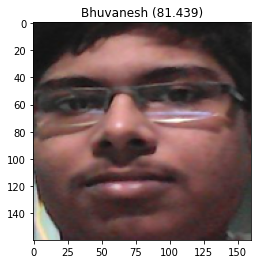

{'spreadsheetId': '1QQ3ZQHltgM6kaqukXt94fNreY7i1Hv7NTuQXN2FDX0g',
 'updatedCells': 5,
 'updatedColumns': 3,
 'updatedRange': 'Sheet1!A1:C2',
 'updatedRows': 2}

In [ ]:

import time
import scipy.ndimage as ndimage
from numpy import load
from numpy import expand_dims
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC
from matplotlib import pyplot
from numpy import asarray
from numpy import savez_compressed
from keras.models import load_model


#TEST PHOTO
#path='/content/drive/MyDrive/ML/project/FRiends/train/Hariram/1639746873652.jpg'
path=take_photo()

#INTIME 
t = time.localtime()
current_time =datetime.now(timezone("Asia/Kolkata")).strftime('%H:%M:%S')

face = extract_face(path)
# store
testX=asarray(face)
#print(testX)
testX_faces = testX


#EMBEDDINGD 
face_pixels=testX
model = load_model('/content/drive/MyDrive/ML/Copy of facenet_keras.h5')
newTestX = list()
testembedding=get_embedding(model, face_pixels,1)
newTestX.append(testembedding)
newTestX = asarray(newTestX)

# load face embeddings
data = load('/content/drive/MyDrive/ML/project/embeddings .npz')
trainX, trainy = data['arr_0'], data['arr_1']
# normalize input vectors
in_encoder = Normalizer(norm='l2')
trainX = in_encoder.transform(trainX)
testX = in_encoder.transform(newTestX)
# label encode targets
out_encoder = LabelEncoder()
out_encoder.fit(trainy)
trainy = out_encoder.transform(trainy)
# fit model
model = SVC(kernel='linear', probability=True)
model.fit(trainX, trainy)
# test model on a random example from the test dataset
test_face_pixels = testX_faces
face_emb = testX[0]
# prediction for the face
samples = expand_dims(face_emb, axis=0)
yhat_class = model.predict(samples)
yhat_prob = model.predict_proba(samples)
# get name
class_index = yhat_class[0]
class_probability = yhat_prob[0,class_index] * 100
predict_names = out_encoder.inverse_transform(yhat_class)
#print(predict_names)
if(class_probability>60):
  print('Predicted: %s (%.3f)' % (predict_names[0], class_probability))
else:
  print('UNKNOWN')
  print('Predicted: %s (%.3f)' % (predict_names[0], class_probability))

pyplot.imshow(test_face_pixels)

if(class_probability>60):
  title = '%s (%.3f)' % (predict_names[0], class_probability)
  prelist=[predict_names[0],current_time]
  if(outtime(prelist,present,current_time)==0):
    present.append(prelist)
  print(current_time)
  #print(present)

else:
  title = '%s' % ("UNKNOWN")
pyplot.title(title)
pyplot.show()

#SHEET
ws.update("A1",present)

In [ ]:
today=datetime.now(timezone('Asia/Kolkata')).strftime("%d/%m/%Y")
print(today)

18/12/2021
